# Metric 1: Monthly Bookings Growth Rate

In [104]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.stats.diagnostic import acorr_ljungbox
from file_utils import read_from_pickle

## Explorative Data Analysis (EDA)

In [105]:
df_contacts = read_from_pickle('./data/df_contacts.pkl')
df_contacts.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27886 entries, 0 to 27886
Data columns (total 14 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   id_guest_anon                         27886 non-null  object        
 1   id_host_anon                          27886 non-null  object        
 2   id_listing_anon                       27886 non-null  object        
 3   ts_interaction_first                  27886 non-null  datetime64[ns]
 4   ts_reply_at_first                     25854 non-null  datetime64[ns]
 5   ts_accepted_at_first                  16415 non-null  datetime64[ns]
 6   ts_booking_at                         11587 non-null  datetime64[ns]
 7   ds_checkin_first                      27886 non-null  datetime64[ns]
 8   ds_checkout_first                     27886 non-null  datetime64[ns]
 9   m_guests                              27886 non-null  float64       
 10  m_i

In [106]:
df_contacts['ts_booking_at'].isnull().value_counts()

ts_booking_at
True     16299
False    11587
Name: count, dtype: int64

In [107]:
df_bookings = df_contacts[df_contacts['ts_booking_at'].notnull()].copy()
df_bookings.shape

(11587, 14)

<Axes: title={'center': 'Monthly Bookings'}, xlabel='period'>

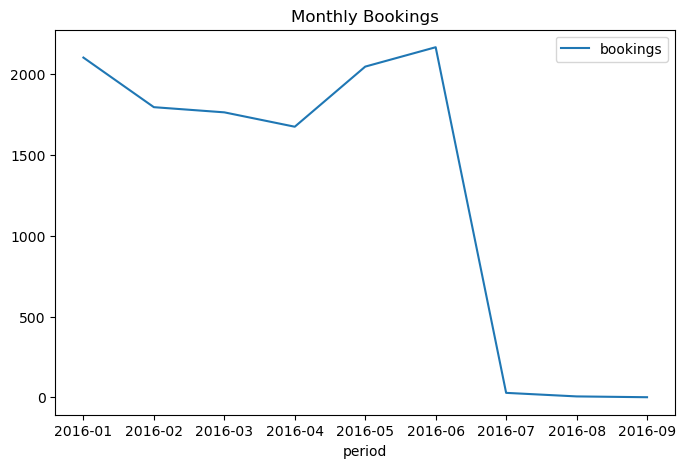

In [108]:
df_monthly_bookings = pd.DataFrame(data={
    'period': df_bookings['ts_booking_at'].dt.to_period(freq='M').astype(str),
    'bookings': df_bookings.index
}).groupby(by=['period'], group_keys=True).count()

df_monthly_bookings.plot(figsize=(8, 5), title='Monthly Bookings')

### Filter out incomplete periods

In [109]:
# filter only the months 2016-01 to 2016-06
df_monthly_bookings = df_monthly_bookings[df_monthly_bookings.index <= '2016-06']

### Checking for outliers

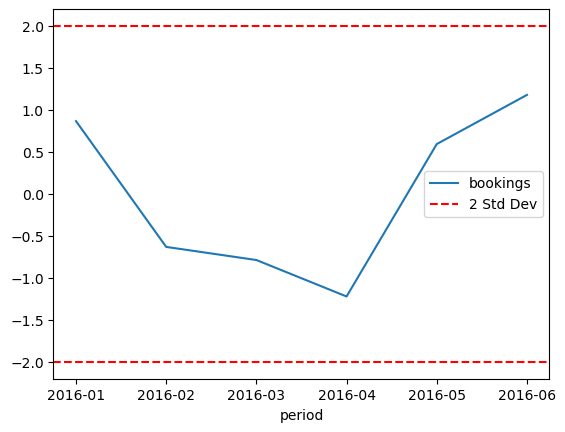

In [110]:
def zscores(series, x=2):
    mean = series.mean()
    std_dev = series.std()
    threshold = x * std_dev
    zscore_series = (series - mean) / std_dev
    return {
        'zscores': zscore_series,
        'threshold': threshold,
        'mean': mean,
        'std_dev': std_dev,
        'max_threshold': mean + threshold,
        'min_threshold': mean - threshold
    }
    
# plot with threshold lines and zscore
x = 2
zscore = zscores(df_monthly_bookings['bookings'], x)
zscore['zscores'].plot()
plt.axhline(x, color='r', linestyle='--', label=f'{x} Std Dev')
plt.axhline(-x, color='r', linestyle='--')
plt.legend()
plt.show()


## Monthly Trend Analysis

In [111]:
def holt_trend(series, smoothing_level=None, smoothing_trend=None, freq='MS'):
    model = ExponentialSmoothing(series, freq=freq, trend='add', damped_trend=False , seasonal=None).fit(smoothing_level=smoothing_level, smoothing_trend=smoothing_trend)
    print('hw params', model.params)
    print('sse', model.sse)
    print('aic', model.aic)
    return pd.DataFrame(data={
        'X': series,
        'level': model.level,
        'trend': model.trend,
        'resid': model.resid,
        'fitted': model.fittedvalues,
    })

# df_hw = hw_trend(df_monthly_bookings['bookings'], smoothing_level=None, smoothing_trend=None)
df_hw = holt_trend(df_monthly_bookings['bookings'], smoothing_level=0.1, smoothing_trend=0.2)

hw params {'smoothing_level': 0.1, 'smoothing_trend': 0.2, 'smoothing_seasonal': nan, 'damping_trend': nan, 'initial_level': 1820.1252528300004, 'initial_trend': 28.011222142080047, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}
sse 224360.3057709945
aic 71.17549446351238


### Residuals: Z-score plot and autocorrelation stats

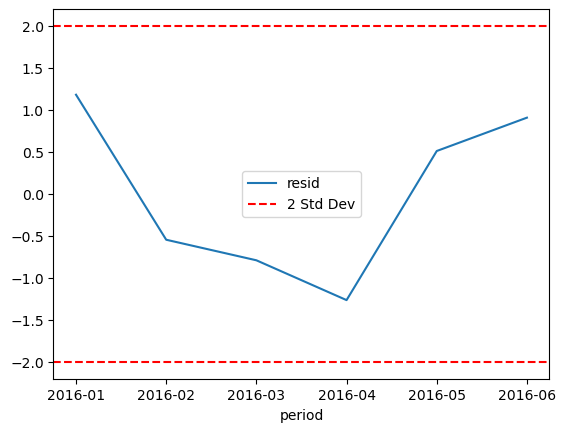

    lb_stat  lb_pvalue
1  0.139936   0.708345


In [112]:
x = 2
zscore = zscores(df_hw['resid'], x)
zscore['zscores'].plot()
plt.axhline(x, color='r', linestyle='--', label=f'{x} Std Dev')
plt.axhline(-x, color='r', linestyle='--')
plt.legend()
plt.show()

# Ljung-Box test for autocorrelation in residuals
acorr = acorr_ljungbox(df_hw['resid'])
print(acorr)

In [113]:
df_hw

,X,level,trend,resid,fitted
period,,,,,
2016-01,2103,1873.622827,33.108493,254.863525,1848.136475
2016-02,1796,1895.658188,30.893866,-110.731320,1906.731320
2016-03,1764,1910.296849,27.642825,-162.552054,1926.552054
2016-04,1675,1911.645707,22.384032,-262.939674,1937.939674
2016-05,2047,1945.326764,24.643437,112.970262,1934.029738
2016-06,2167,1989.673181,28.584033,197.029799,1969.970201


### Level and trend components plot

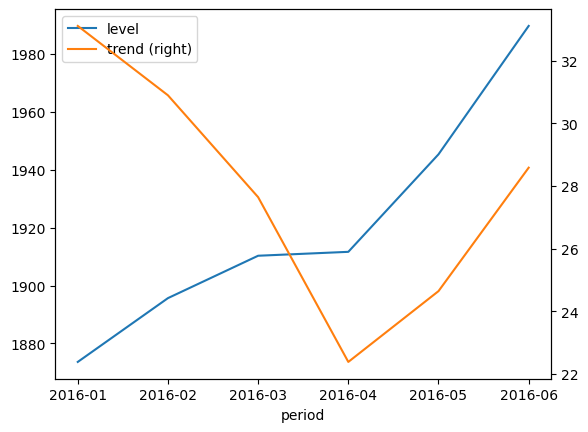

In [114]:
df_hw.plot(y=['level', 'trend'], secondary_y='trend', kind='line')
plt.show()


### Metric calculation

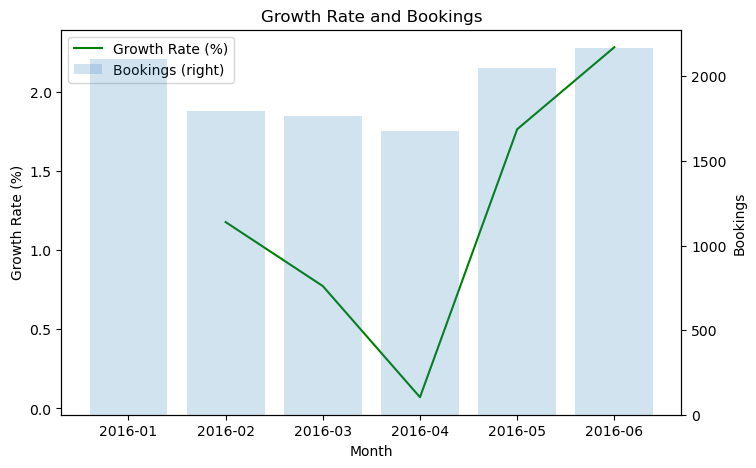

In [115]:
df_hw['growth_rate'] = df_hw['level'].pct_change()
df_hw['growth_rate'] = df_hw['growth_rate'] * 100

# plot growth rate and bookings
fig, ax1 = plt.subplots(figsize=(8, 5))
ax2 = ax1.twinx()
ax1.plot(df_hw['growth_rate'], color='g')
ax2.bar(df_hw.index, df_hw['X'], alpha=0.2)

## add legends
lns1 = ax1.get_lines()
lns2 = ax2.get_children()[1:3]
ax1.legend(lns1 + lns2, ['Growth Rate (%)', 'Bookings (right)'], loc=0)

## add labels
ax1.set_title('Growth Rate and Bookings')
ax1.set_xlabel('Month')
ax1.set_ylabel('Growth Rate (%)')
ax2.set_ylabel('Bookings')

plt.show()

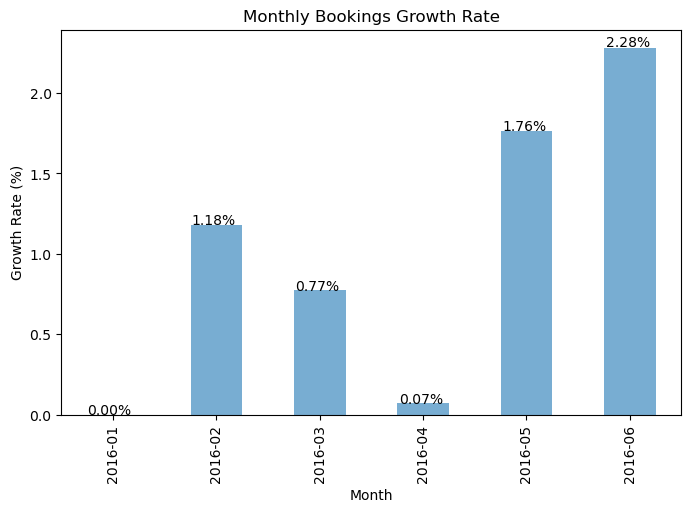

In [118]:
ax = df_hw.plot(y=['growth_rate'], secondary_y='trend', kind='bar', figsize=(8, 5), alpha=0.6)
# add data labels as percentages
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', (p.get_x() * 1.005, p.get_height() * 1.005))

ax.legend().remove()
ax.set_title('Monthly Bookings Growth Rate')
ax.set_xlabel('Month')
ax.set_ylabel('Growth Rate (%)')

# save plot to file
plt.savefig('./plots/monthly-bookings-growth-rate.png', bbox_inches='tight')

plt.show()